In [57]:
import pandas as pd
from num2words import num2words
import re

from sympy import limit
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain.chains import RetrievalQA

In [58]:
# Set the float display option
pd.options.display.float_format = '{:.2f}'.format

def load_data(file, label_instances=False):
    data = pd.read_csv(file)
    if label_instances:
        data['anomaly'] = 0
    if 'time' in data.columns:
        data.drop('time', axis=1, inplace=True)
    if 'sut.bat.i' in data.columns:
        data['sut.bat.i'] = data['sut.bat.i'].abs()
    data.dropna(inplace=True)
    return data

healthy_file = './../data/battery_healthy.csv'
healthy_data = load_data(healthy_file)

test_file = './../data/battery_runtime_fault1.csv'
test_data = load_data(test_file)

powertrain_file = './../data/powertrain/correctBehavior/TB3_correct_behavior_load_0.csv'
powertrain_file_f1 = './../data/powertrain/faultyBehavior/TB3_f1_behavior_load_0.csv'
powertrain_file_f2 = './../data/powertrain/faultyBehavior/TB3_f2_behavior_load_0.csv'

powertrain_data = load_data(powertrain_file)
powertrain_data_f1 = load_data(powertrain_file_f1)
powertrain_data_f2 = load_data(powertrain_file_f2)

powertrain_data.columns = ['battery\'s current', 'battery\'s voltage', 'rotation speed of electric motor', 'mode of h-bridge']
powertrain_data_f2.columns = ['battery\'s current', 'battery\'s voltage', 'rotation speed of electric motor', 'mode of h-bridge']
powertrain_data_f1.columns = ['battery\'s current', 'battery\'s voltage', 'rotation speed of electric motor', 'mode of h-bridge']
powertrain_data.describe()

,battery's current,battery's voltage,rotation speed of electric motor,mode of h-bridge
count,250034.00,250034.00,250034.00,250034.00
mean,3.31,13.67,1.15,4.44
std,4.33,0.43,43.73,0.79
min,0.00,12.76,-72.14,3.00
25%,0.00,13.10,-0.00,4.00
50%,0.00,14.00,-0.00,5.00
75%,8.98,14.00,0.00,5.00
max,12.42,14.00,72.14,5.00


In [59]:
healthy_data.tail()

,time_s,no_unit_none,temperature_degC,temperature_degC_1,temperature_degC_2,temperature_degC_3,temperature_degC_4,temperature_degC_5,amperage_A,power_W,velocity_km_h,no_unit_none_1,temperature_degC_6,volflow_l_min
10796,5398.00,3000,-10,-10,-10,20.92,23.52,18.54,-0.78,-333.33,0.00,2,25.00,1.08
10797,5398.50,3000,-10,-10,-10,20.92,23.52,18.54,-0.78,-333.33,0.00,2,25.00,1.08
10798,5399.00,3000,-10,-10,-10,20.92,23.51,18.54,-0.78,-333.33,0.00,2,25.00,1.08
10799,5399.50,3000,-10,-10,-10,20.92,23.51,18.54,-0.78,-333.33,0.00,2,25.00,1.08
10800,5400.00,3000,-10,-10,-10,20.91,23.51,18.54,-0.78,-333.33,0.00,2,25.00,1.08


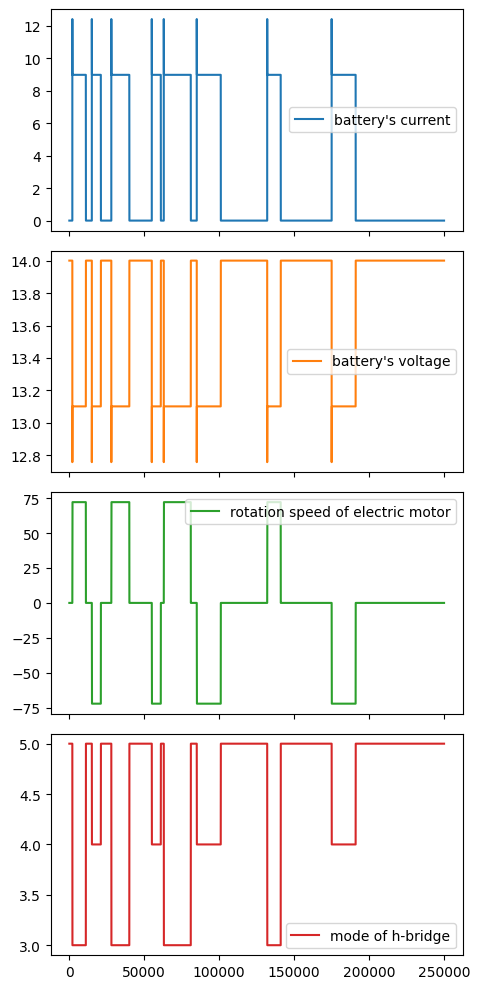

In [60]:
powertrain_data.plot(subplots=True, figsize=(5, 10)); plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [61]:
def text_encoder(seperator, data):
    encoded_df = pd.DataFrame([data.columns]*len(data), columns=data.columns)+ seperator + data.astype(str)
    encoded_df = encoded_df.apply(lambda x: " and ".join(x), axis=1)
    #encoded_df = encoded_df.apply(lambda x: re.sub(r"[-+]?(?:\d*\.*\d+)", lambda m: num2words(m.group()), x))
    return encoded_df

def text_encode(data, file, prefix):
    file = file.replace('.csv', '')
    s = " is "
    encoded_df = text_encoder(s, data=data)
    encoded_df.to_csv(f"{file}_{prefix}_{s.strip()}.csv", index=False, header=False, float_format='%.2f')
    encoded_df.apply(lambda x: re.sub(r"[-+]?(?:\d*\.*\d+)", lambda m: num2words(m.group()), x)).to_csv(f"{file}_{prefix}_{s.strip()}_num2words.csv", index=False, header=False, float_format='%.2f')
    return encoded_df

In [62]:
# encoded_healthy_df = text_encode(healthy_data, healthy_file, 'text_encoded_with')
# encoded_healthy_rounded_df = text_encode(healthy_data.round(2), healthy_file, 'roundend_and_text_encoded_with')

# encoded_test_df = text_encode(test_data, test_file, 'text_encoded_with')
# encoded_test_rounded_df = text_encode(test_data.round(2), test_file, 'rounded_and_text_encoded_with')

encoded_powertrain_df = text_encode(powertrain_data, powertrain_file, 'text_encoded_with')
encoded_powertrain_rounded_df = text_encode(powertrain_data.round(2), powertrain_file, 'rounded_and_text_encoded_with')

encoded_powertrain_f1_df = text_encode(powertrain_data_f1, powertrain_file_f1, 'text_encoded_with')
encoded_powertrain_f1_rounded_df = text_encode(powertrain_data_f1.round(2), powertrain_file_f1, 'rounded_and_text_encoded_with')

# encoded_powertrain_f2_df = text_encode(powertrain_data_f2, powertrain_file_f2, 'text_encoded_with')
# encoded_powertrain_f2_rounded_df = text_encode(powertrain_data_f2.round(2), powertrain_file_f2, 'rounded_and_text_encoded_with')

In [18]:
loader = CSVLoader(file_path=f"./../data/battery_healthy_text_encoded_with_is_num2words.csv")
data = loader.load()

TEXT_SPLITTER_CHUNK_PARAMS = {
    "chunk_size": 2000,
    "chunk_overlap": 0,
    "length_function": len,
}

text_splitter = RecursiveCharacterTextSplitter(**TEXT_SPLITTER_CHUNK_PARAMS)
texts = text_splitter.split_documents(data)

In [19]:
docs = texts[0:10]
docs

[Document(page_content='time_s is zero and no_unit_none is three thousand and temperature_degC is minus ten and temperature_degC_one is minus ten and temperature_degC_two is minus ten and temperature_degC_three is minus ten and temperature_degC_four is minus ten and temperature_degC_five is minus ten and amperage_A is zero and power_W is zero and velocity_km_h is zero and no_unit_none_one is zero and temperature_degC_six is zero and volflow_l_min is zero: time_s is zero point five and no_unit_none is three thousand and temperature_degC is minus ten and temperature_degC_one is minus ten and temperature_degC_two is minus ten and temperature_degC_three is minus ten and temperature_degC_four is minus ten and temperature_degC_five is minus ten and amperage_A is zero and power_W is zero and velocity_km_h is zero and no_unit_none_one is two and temperature_degC_six is fifteen and volflow_l_min is ten point eight five', metadata={'source': './../data/battery_healthy_text_encoded_with_is_num2wo

In [10]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama
from langchain.vectorstores import Qdrant
# set up OpenAI Embeddings
from langchain.embeddings import OllamaEmbeddings
embeddings = OllamaEmbeddings(model='mistral') 

# set up the qdrant database
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="my_documents",
)

llm = ChatOllama(
    model="mistral", temperature=0)
    #callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),

question = "Summarize this text in 5 sentences. Do you see anything special about this cyber physical system? Assume that a temperature of 1000 degrees is a normal temperature."

qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=qdrant.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

KeyboardInterrupt: 